<a href="https://colab.research.google.com/github/Real1CM/LLM_Z2H/blob/main/aboutTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 552, done.
remote: Total 552 (delta 0), reused 0 (delta 0), pack-reused 552 (from 1)
Receiving objects: 100% (552/552), 17.89 MiB | 14.85 MiB/s, done.
Resolving deltas: 100% (302/302), done.


In [2]:
%cd "pytorch_advanced"
%cd "1_image_classification"

/content/pytorch_advanced
/content/pytorch_advanced/1_image_classification


In [3]:
import os
import urllib.request
import zipfile


data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)
    zip.close()

    os.remove(save_path)

In [4]:
import glob # pathnames matching
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn # neural network
import torch.optim as optim # optimization algorithms
import torch.utils.data as data #data loading utility
import torchvision
from torchvision import models, transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [5]:
# Be called in DataSet class
class ImageTransform():
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train': transforms.Compose([ # train
            transforms.RandomResizedCrop( # crop the photo
                resize, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(), # 50% flip the photo
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([ # validate
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

  def __call__(self, img, phase='train'):
    return self.data_transform[phase](img)

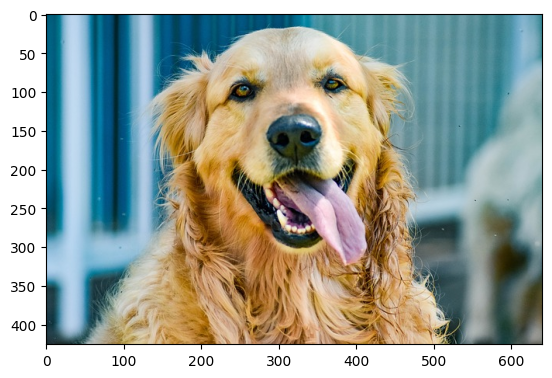

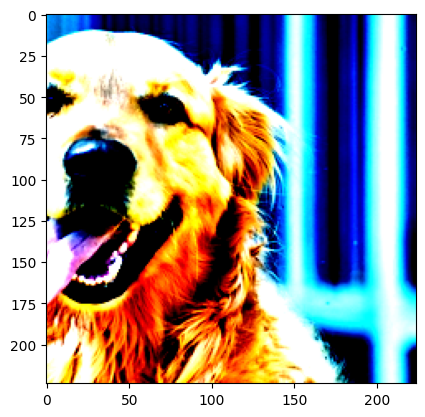

In [6]:
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [7]:
def make_datapath_list(phase="train"):
  rootpath = "./data/hymenoptera_data/"
  target_path = osp.join(rootpath+phase+'/**/*.jpg') # 路径拼接
  print(target_path)
  path_list = []

  for path in glob.glob(target_path): # 根据target_path路径查找路径
    path_list.append(path)

  return path_list

train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")
train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/ants/474806473_ca6caab245.jpg',
 './data/hymenoptera_data/train/ants/475961153_b8c13fd405.jpg',
 './data/hymenoptera_data/train/ants/2288450226_a6e96e8fdf.jpg',
 './data/hymenoptera_data/train/ants/450057712_771b3bfc91.jpg',
 './data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train/ants/ant photos.jpg',
 './data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train/ants/392382602_1b7bed32fa.jpg',
 './data/hymenoptera_data/train/ants/384191229_5779cf591b.jpg',
 './data/hymenoptera_data/train/ants/522415432_2218f34bf8.jpg',
 './data/hymenoptera_data/train/ants/6240329_72c01e663e.jpg',
 './data/hymenoptera_data/train/ants/2265824718_2c96f485da.jpg',
 './data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train/ants/1489674356_09d48dde0a.jpg',
 './data/hymenoptera_data/train/ants/5650366_e22b7e1065.jpg',
 './data/hymenoptera_data/train/ants/154124431_6

In [8]:
#DataSet
class HymenopteraDataset(data.Dataset): #继承了Dataset基类
  def __init__(self, file_list, transform=None, phase='train'):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, index):
    img_path = self.file_list[index]
    img = Image.open(img_path)

    img_transformed = self.transform(
        img, self.phase)

    if self.phase == "train":
        label = img_path[30:34]
    elif self.phase == "val":
        label = img_path[28:32]

    if label == "ants":
        label = 0
    elif label == "bees":
        label = 1

    return img_transformed, label

train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [9]:
batch_size = 32 # 一批32个
# DataLoader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True) # shuffle会重新排列数据
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(dataloaders_dict["train"]) # 返回迭代器对象
inputs, labels = next(batch_iterator) #迭代器的第一个元素
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0])


In [10]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
criterion = nn.CrossEntropyLoss() # 损失函数

In [12]:
params_to_update = []
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
  if name in update_param_names:  # 网络中需要更新的参数
    param.requires_grad = True # true是梯度要算
    params_to_update.append(param)
  else:
    param.requires_grad = False

print("Parameters to update:")
print(params_to_update)

Parameters to update:
[Parameter containing:
tensor([[-0.0112, -0.0021, -0.0150,  ..., -0.0098,  0.0003, -0.0043],
        [ 0.0073,  0.0097, -0.0029,  ..., -0.0058,  0.0037, -0.0002]],
       requires_grad=True), Parameter containing:
tensor([0.0046, 0.0064], requires_grad=True)]


In [13]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [14]:
# 验证
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs): # last para stand for time mapping all datasets
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            if (epoch == 0) and (phase == 'train'):
                continue

            for inputs, labels in tqdm(dataloaders_dict[phase]): # 进度条
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # 异常处理
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [15]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
-------------


100%|██████████| 5/5 [01:36<00:00, 19.33s/it]


val Loss: 0.7769 Acc: 0.4641
Epoch 2/2
-------------


100%|██████████| 8/8 [02:30<00:00, 18.79s/it]


train Loss: 0.5235 Acc: 0.6790


100%|██████████| 5/5 [01:33<00:00, 18.71s/it]

val Loss: 0.1789 Acc: 0.9412
